In [155]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize
import scipy.integrate
import scipy.stats
import scipy.special

In [7]:
matplotlib.rcParams['figure.figsize'] = (10, 8)

In [144]:
file = uproot.open("../../geant/data/bigdatasample/output_75_full_re_coincidences_3D.root")
data = file['Pairwise Distances'].arrays(library='pd')
meta = file['Metadata'].arrays(library='pd')

In [145]:
data = data[data['Particle 2'] == 'e-']

In [146]:
(bars, bins) = np.histogram(data['Distance (mm)'], bins=1000)
width = bins[1] - bins[0]

# Iterations is how many times particlesPerPulse were selected. It is the total number of pulses in 1 second simulated
iterations = meta['Iterations'][0]
particlesPerPulse = meta['Particles Per Pulse'][0]
generatorParticlesPerSecond = 1e6

roi = slice(0, 150)

barsigma = np.where(np.sqrt(bars[roi]) == 0, 1, np.sqrt(bars[roi]))
bars = bars * generatorParticlesPerSecond / iterations / particlesPerPulse
barsigma = barsigma * generatorParticlesPerSecond / iterations / particlesPerPulse

bins = np.convolve(bins, np.ones(2) / 2, mode='valid')

In [147]:
def poly4(x, a, b, c, d):
    return a * x + b * x ** 2 + c * x ** 3 + d * x ** 4

popt, pcov = scipy.optimize.curve_fit(poly4, bins[roi], bars[roi], absolute_sigma=True, sigma=barsigma, bounds=([0, 0, 0, 0],[np.inf, np.inf, np.inf, np.inf]))

fitx = np.linspace(0, np.max(bins[roi]), 1000)
fity = poly4(fitx, *popt)

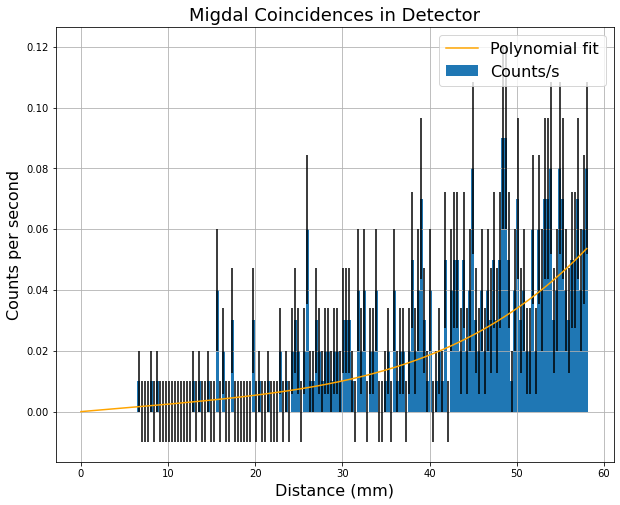

In [148]:
fig, ax = plt.subplots()

ax.bar(bins[roi], bars[roi], width, yerr=barsigma, label='Counts/s')
ax.plot(fitx, fity, color='orange', zorder=10, label='Polynomial fit')

ax.grid()
ax.legend(fontsize=16)

ax.set_xlabel('Distance (mm)', fontsize=16)
ax.set_ylabel('Counts per second', fontsize=16)
ax.set_title('Migdal Coincidences in Detector', fontsize=18)

plt.show()

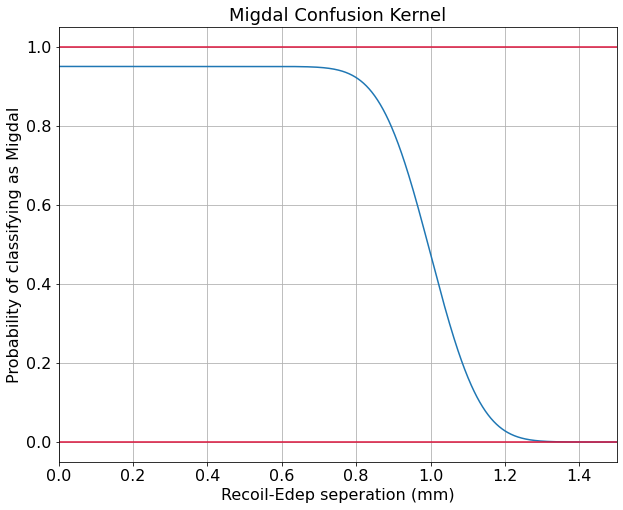

In [181]:
def erfKernel(x_list, A, d, w):
    return A * (0.5 * scipy.special.erf((d - x_list) / w) + 0.5)

fig, ax = plt.subplots()

A = 0.95
kernelCenter = 1
w = 0.15

d = np.linspace(0, 1.5, 1000)
confusionKernel = erfKernel(d, A, kernelCenter, w)

ax.plot(d, confusionKernel)

ax.axhline(0, color='crimson')
ax.axhline(1, color='crimson')

ax.set_xlim(0, 1.5)

ax.grid()

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax.set_xlabel('Recoil-Edep seperation (mm)',fontsize=16)
ax.set_ylabel('Probability of classifying as Migdal',fontsize=16)
ax.set_title('Migdal Confusion Kernel',fontsize=18)

plt.show()

In [149]:
# Antiderivative of poly4 for finding area under curve
def int_poly4(x, a, b, c, d):
    return a * x ** 2 / 2 + b * x ** 3 / 3 + c * x ** 4 / 4 + d * x ** 5 / 5

# Left endpoint is 0, right endpoint is x. This is gradient w.r.t. parameters of value of integral
def grad_int_poly4(x, a, b, c, d):
    return np.array([x ** 2 / 2, x ** 3 / 3, x ** 4 / 4, x ** 5 / 5])

def CoincidencesPerSecond(distanceResolution):
    coincidencesPerSecond = int_poly4(distanceResolution, *popt)
    errcoincidencesPerSecond = np.sqrt(pcov @ grad_int_poly4(distanceResolution, *popt) @ grad_int_poly4(distanceResolution, *popt))
    
    return (coincidencesPerSecond, errcoincidencesPerSecond)

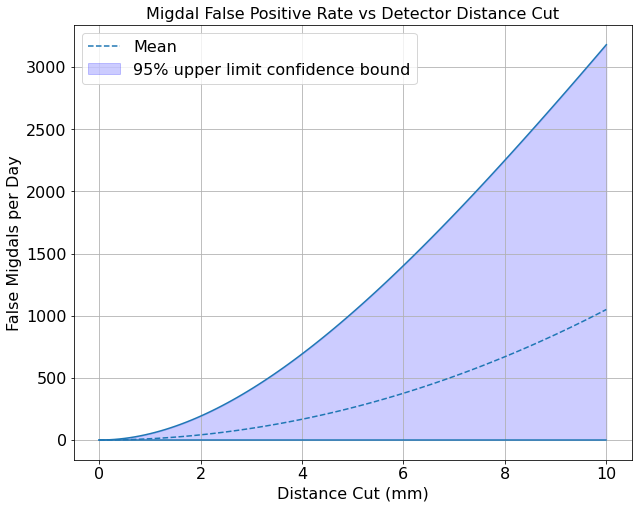

In [150]:
distanceCuts = np.linspace(0, 10, 100)

coincidencesPerSecond = np.array([CoincidencesPerSecond(d) for d in distanceCuts])
errcoincidencesPerSecond = coincidencesPerSecond[:, 1]
coincidencesPerSecond = coincidencesPerSecond[:, 0]

coincidencesPerDay = coincidencesPerSecond * 24 * 3600
upperboundPerDay = (coincidencesPerSecond + 1.64 * errcoincidencesPerSecond) * 24 * 3600
lowerboundPerDay = np.zeros_like(upperboundPerDay)
#lowerboundPerDay = (coincidencesPerSecond - 1.96 * errcoincidencesPerSecond) * 24 * 3600
#lowerboundPerDay = np.where(lowerboundPerDay < 0, 0, lowerboundPerDay)

fig, ax = plt.subplots()

ax.plot(distanceCuts, upperboundPerDay, color='tab:blue')
ax.plot(distanceCuts, lowerboundPerDay, color='tab:blue')
ax.plot(distanceCuts, coincidencesPerDay, '--', color='tab:blue', label='Mean')

ax.fill_between(distanceCuts, lowerboundPerDay, upperboundPerDay, color='blue', alpha=.2, label='95% upper limit confidence bound')

ax.grid()
ax.legend(fontsize=16)

ax.set_xlabel('Distance Cut (mm)', fontsize=16)
ax.set_ylabel('False Migdals per Day', fontsize=16)
ax.set_title('Migdal False Positive Rate vs Detector Distance Cut', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

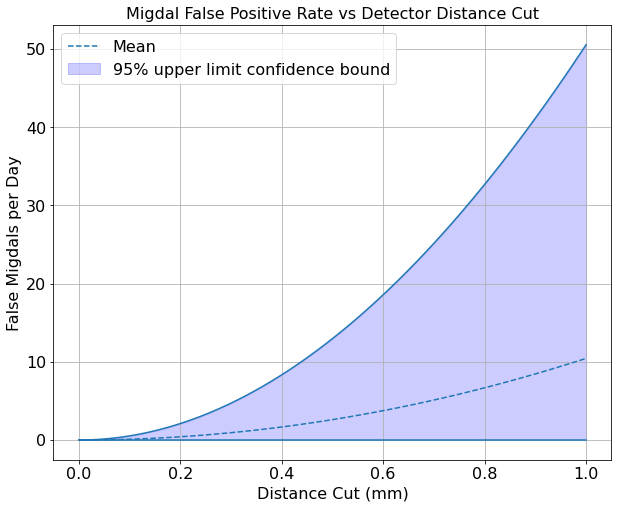

In [151]:
distanceCuts = np.linspace(0, 1, 100)

coincidencesPerSecond = np.array([CoincidencesPerSecond(d) for d in distanceCuts])
errcoincidencesPerSecond = coincidencesPerSecond[:, 1]
coincidencesPerSecond = coincidencesPerSecond[:, 0]

coincidencesPerDay = coincidencesPerSecond * 24 * 3600
upperboundPerDay = (coincidencesPerSecond + 1.64 * errcoincidencesPerSecond) * 24 * 3600
lowerboundPerDay = np.zeros_like(upperboundPerDay)
#lowerboundPerDay = (coincidencesPerSecond - 1.96 * errcoincidencesPerSecond) * 24 * 3600
#lowerboundPerDay = np.where(lowerboundPerDay < 0, 0, lowerboundPerDay)

fig, ax = plt.subplots()

ax.plot(distanceCuts, upperboundPerDay, color='tab:blue')
ax.plot(distanceCuts, lowerboundPerDay, color='tab:blue')
ax.plot(distanceCuts, coincidencesPerDay, '--', color='tab:blue', label='Mean')

ax.fill_between(distanceCuts, lowerboundPerDay, upperboundPerDay, color='blue', alpha=.2, label='95% upper limit confidence bound')

ax.grid()
ax.legend(fontsize=16)

ax.set_xlabel('Distance Cut (mm)', fontsize=16)
ax.set_ylabel('False Migdals per Day', fontsize=16)
ax.set_title('Migdal False Positive Rate vs Detector Distance Cut', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()